In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve, precision_score, recall_score, make_scorer
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier

import warnings

In [2]:
data = pd.read_csv('transactions.csv', index_col=0)

In [3]:
data.head()

,merchant,time,amount_usd_in_cents
1,faa029c6b0,2034-06-17 23:34:14,6349
2,ed7a7d91aa,2034-12-27 00:40:38,3854
3,5608f200cf,2034-04-30 01:29:42,789
4,15b1a0d61e,2034-09-16 01:06:23,4452
5,4770051790,2034-07-22 16:21:42,20203


In [4]:
data.shape

(1513719, 3)

In [5]:
data.dtypes

merchant               object
time                   object
amount_usd_in_cents     int64
dtype: object

# Exploratory Data Analysis

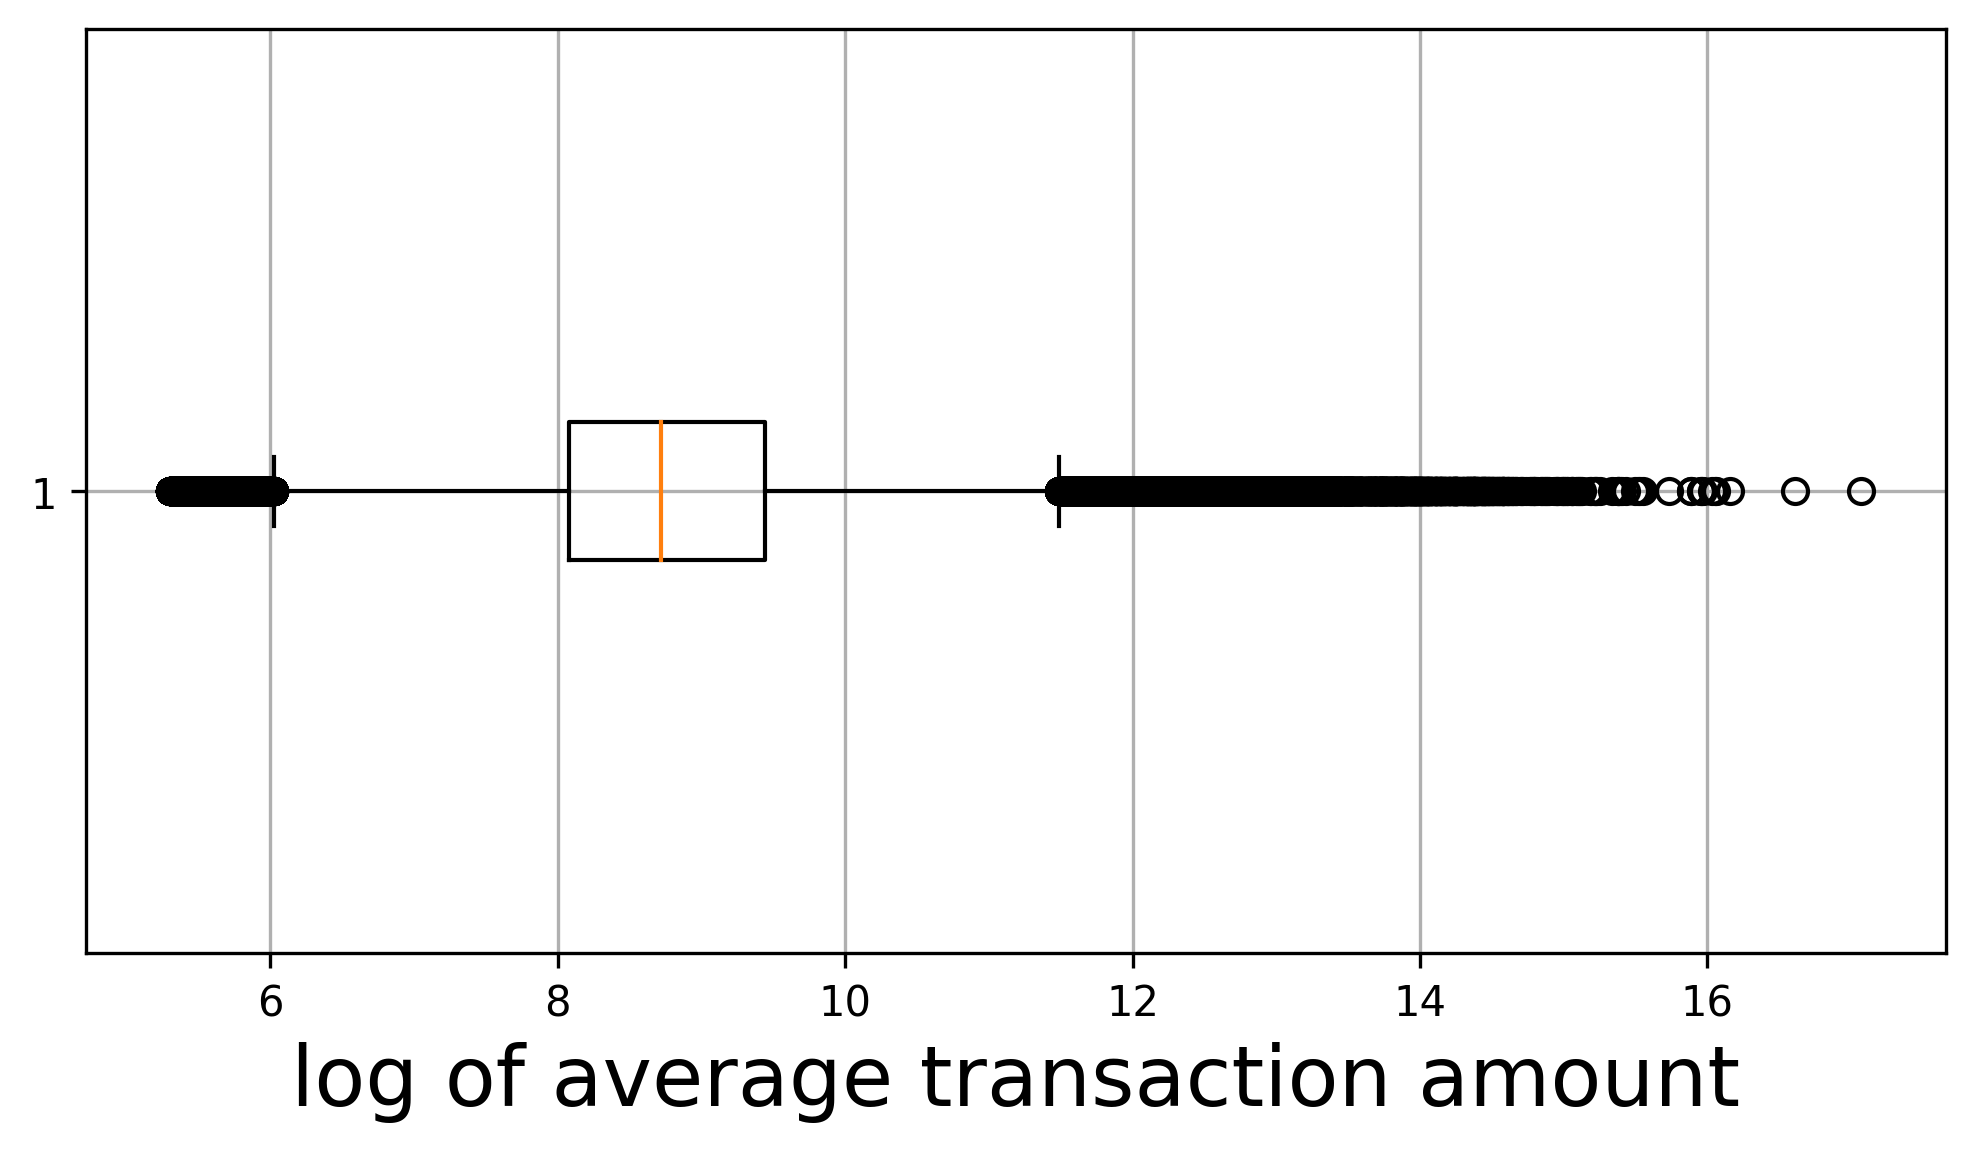

In [6]:
figure = plt.figure(figsize=(8, 4), dpi=300)
plt.boxplot(np.log(data.amount_usd_in_cents), vert=False)
plt.xlabel(('log of average transaction amount'), size=20)
plt.grid()

In [7]:
viz_data = data.copy()
viz_data['time'] = data['time'].apply(lambda x: x[:7])
monthly_txn = viz_data[['time', 'amount_usd_in_cents']].groupby(['time']).sum().reset_index()

<BarContainer object of 24 artists>

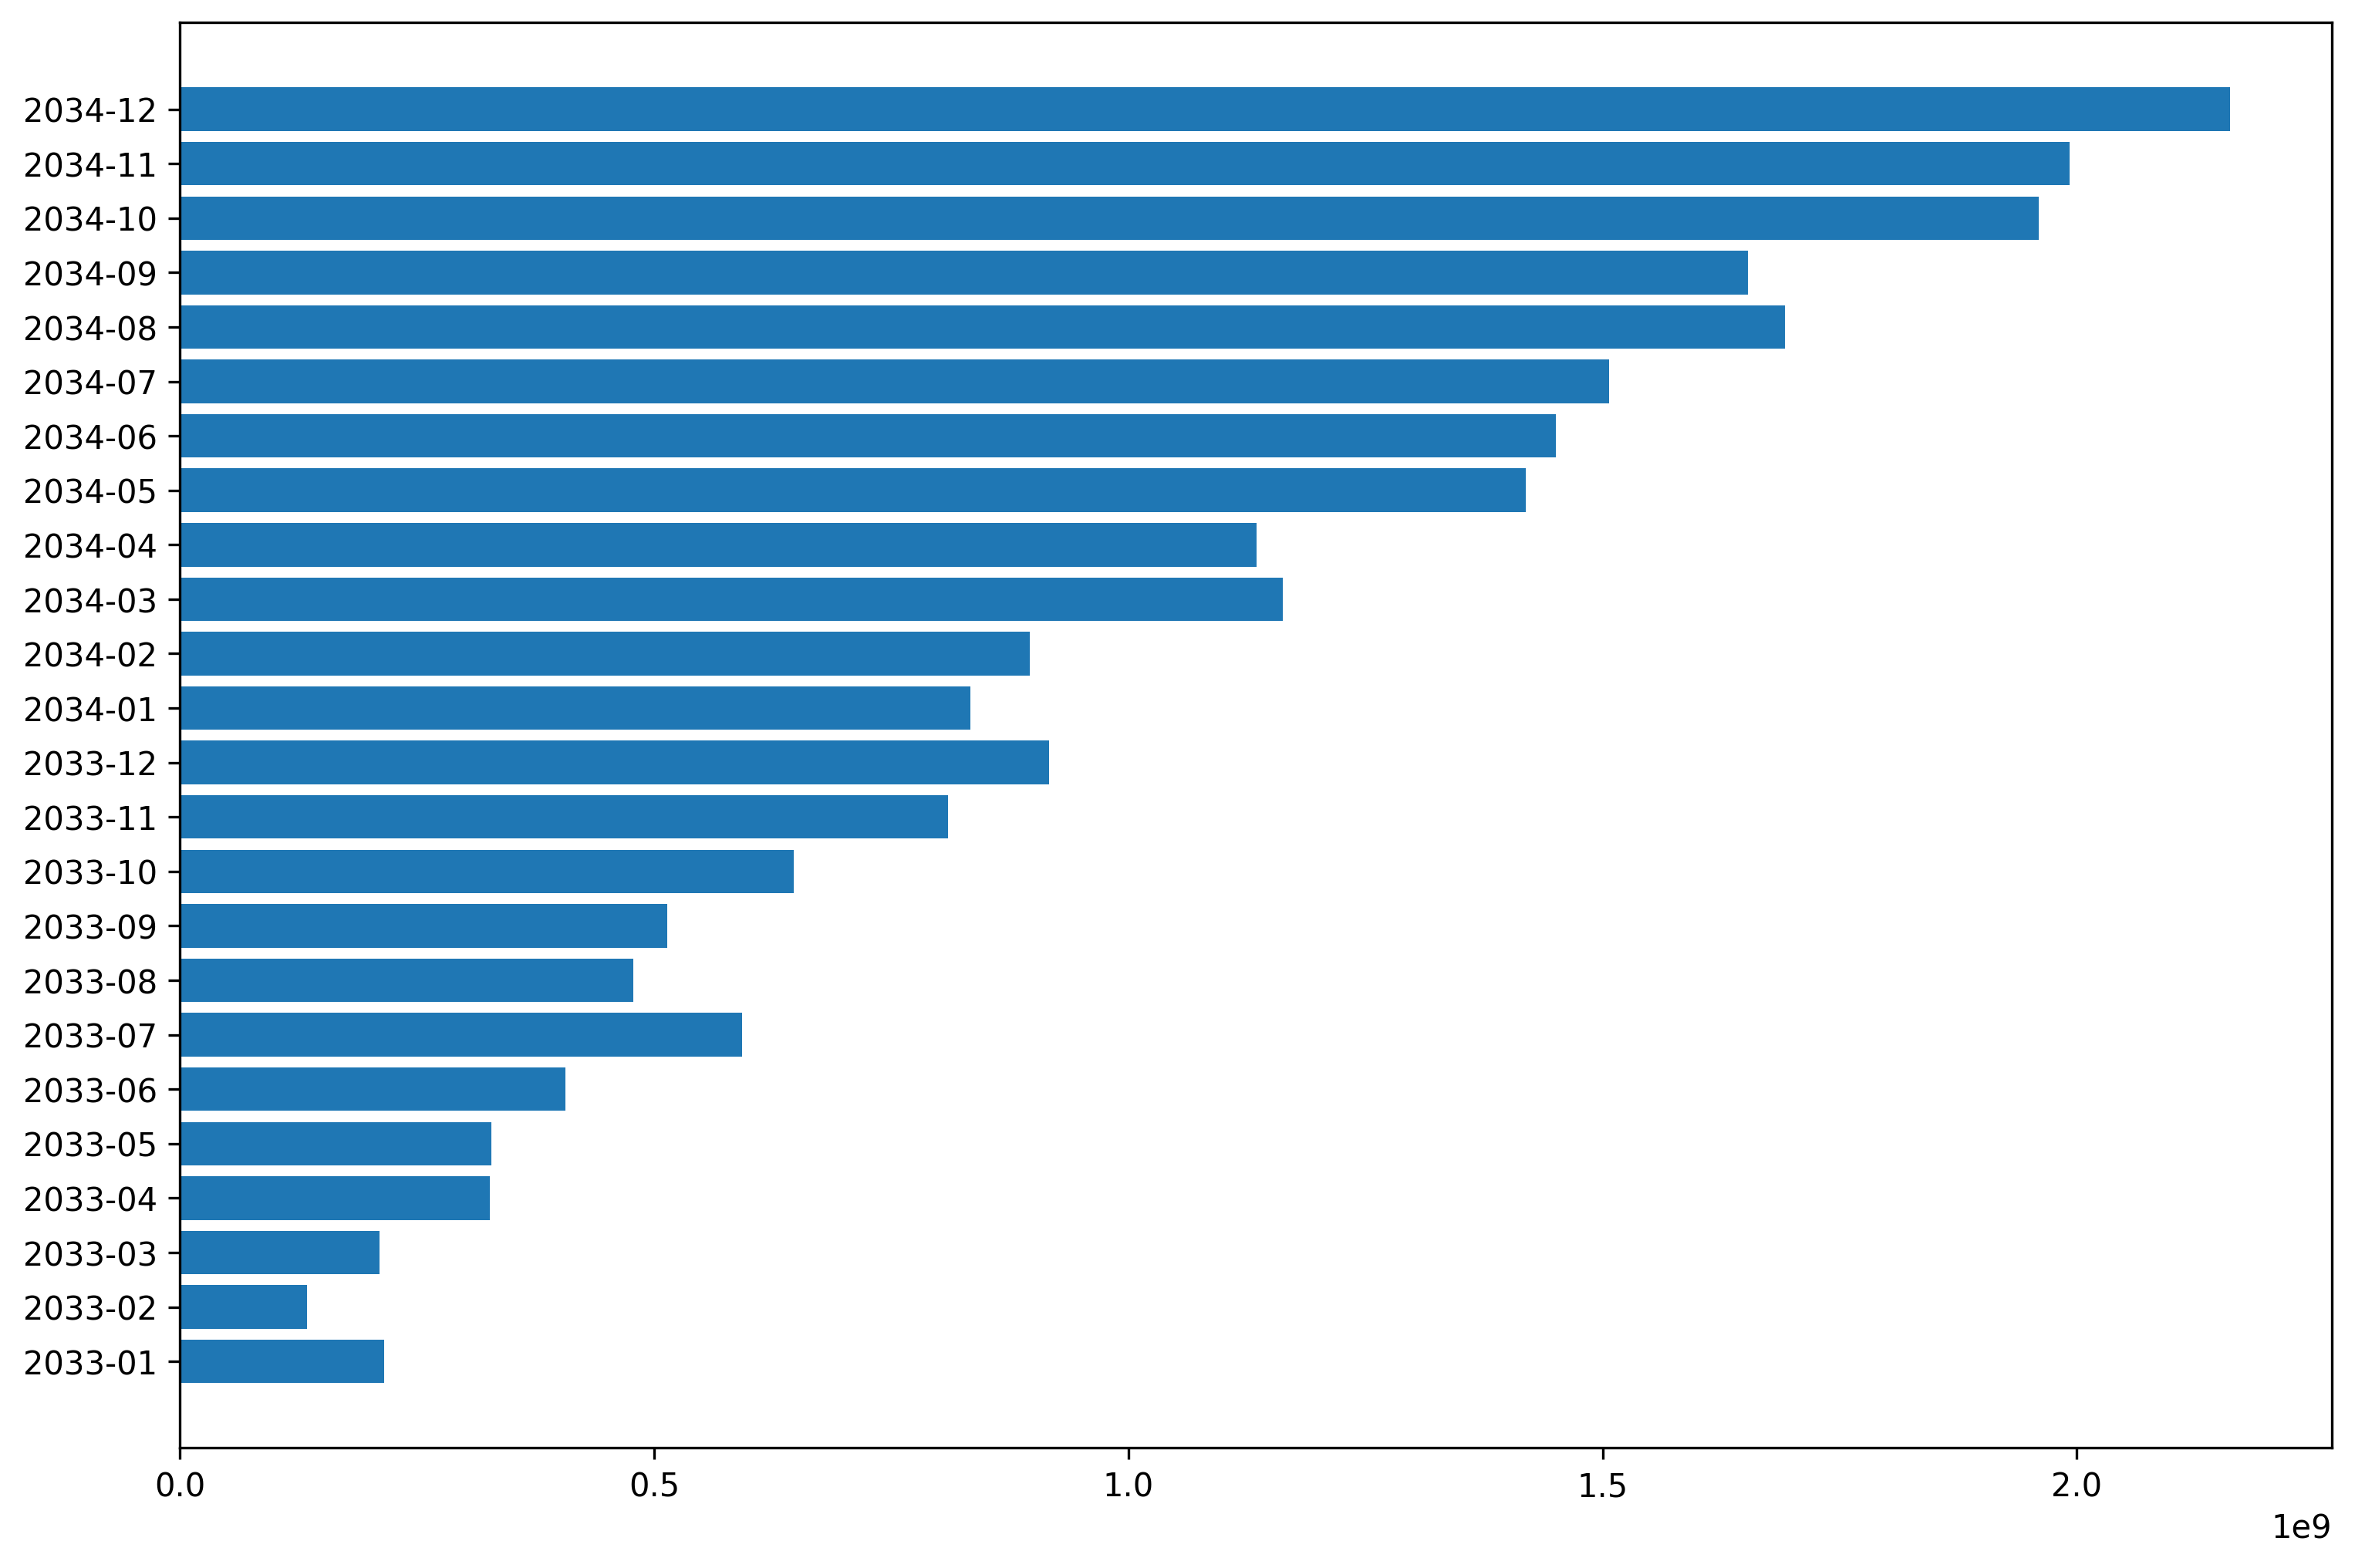

In [8]:
figure = plt.figure(figsize=(12, 8), dpi=300)
plt.barh(width = monthly_txn['amount_usd_in_cents'], y = monthly_txn['time'])

# Data Preprocessing

In [9]:
# some hyperparameters 
# I will discard customers whoes last transaction happened before `thres_date` since for these customers, we don't 
# have all of their data in the last half a year before its last transaction
thres_date = '2033-07-01'

# I will choose this `spot` as an oberservation point, which means at this date, for each customer, how long did
# they stop using this product and have no transactction records
spot = '2035-01-01'

# this parameter means, customers above `division_rate` percentile are regarded as 'high' and below are 'low'
devision_rate = 0.8

# no transaction in recent 60 days means churn
churn_day = 60

In [10]:
def generate_user_data(data, thres_date='2033-07-01', spot='2035-01-01', division_rate=0.8, churn_day=90):
    data['date'] = pd.to_datetime(data.loc[:, 'time'])  # transfer str to date

    # create a user table with primary key of merchant id
    user = pd.DataFrame(data.merchant.drop_duplicates())
    user.index = user.merchant

    # get some features of each user, with the most recent txn date, and txn amount description
    user['last_txn_date'] = data[['merchant', 'date']].groupby('merchant').max() 

    # filter out users whoes last transaction date is before the threshold date
    user = user[user['last_txn_date'] > pd.to_datetime(thres_date)]

    user['avg_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').mean()
    user['med_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').median()
    user['total_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').sum()
    user['total_txn_times'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').count()

    # get the txn gap to define churn
    user['gap_last_txn'] = (pd.to_datetime(spot) - user['last_txn_date']).dt.days
    user['churn'] = (user['gap_last_txn'] >= churn_day).astype(int)

    # Simply use a pareto principle to determine the threshold might work
    threshold_amount = user.total_amount.quantile(devision_rate)
    threshold_times = user.total_txn_times.quantile(devision_rate)

    # above the threshold I label them as 1
    user['frequency_type'] = (user['total_txn_times'] > threshold_times).astype(int)
    user['monetary_type'] = (user['total_amount'] > threshold_amount).astype(int)
    
    return user

In [11]:
user = generate_user_data(data, churn_day=churn_day)
user

,merchant,last_txn_date,avg_amount,med_amount,total_amount,total_txn_times,gap_last_txn,churn,frequency_type,monetary_type
merchant,,,,,,,,,,
faa029c6b0,faa029c6b0,2034-12-30 20:57:25,16729.992647,14599.0,9101116,544,1,0,1,1
ed7a7d91aa,ed7a7d91aa,2034-12-27 00:40:38,16958.500000,6492.0,271336,16,4,0,0,0
5608f200cf,5608f200cf,2034-12-31 04:44:54,819.675878,820.0,20911571,25512,0,0,1,1
15b1a0d61e,15b1a0d61e,2034-12-30 21:21:42,5765.639155,4466.0,3003898,521,1,0,1,1
4770051790,4770051790,2034-12-31 02:52:53,45291.076655,28854.5,25997078,574,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
41f6054841,41f6054841,2034-03-11 00:45:57,1233.000000,1233.0,1233,1,295,1,0,0
cce748c02b,cce748c02b,2033-08-15 15:05:50,406528.000000,406528.0,406528,1,503,1,0,0
9506efbbbd,9506efbbbd,2034-11-22 01:08:25,13536.000000,13536.0,13536,1,39,0,0,0


In [12]:
user.describe()

,avg_amount,med_amount,total_amount,total_txn_times,gap_last_txn,churn,frequency_type,monetary_type
count,1.369000e+04,1.369000e+04,1.369000e+04,13690.000000,13690.000000,13690.000000,13690.000000,13690.000000
mean,3.828956e+04,3.151723e+04,1.699124e+06,109.635646,113.667421,0.453689,0.200000,0.200000
std,1.401150e+05,1.101469e+05,6.573532e+06,539.791248,141.528301,0.497869,0.400015,0.400015
min,2.010000e+02,2.010000e+02,2.010000e+02,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.759083e+03,4.530250e+03,3.773825e+04,3.000000,9.000000,0.000000,0.000000,0.000000
50%,1.106209e+04,8.317000e+03,1.694545e+05,11.000000,44.000000,0.000000,0.000000,0.000000
75%,2.775318e+04,2.031988e+04,8.787700e+05,47.000000,182.000000,1.000000,0.000000,0.000000
max,8.887465e+06,8.570644e+06,2.369072e+08,25512.000000,548.000000,1.000000,1.000000,1.000000


### Exploratory Data Analysis

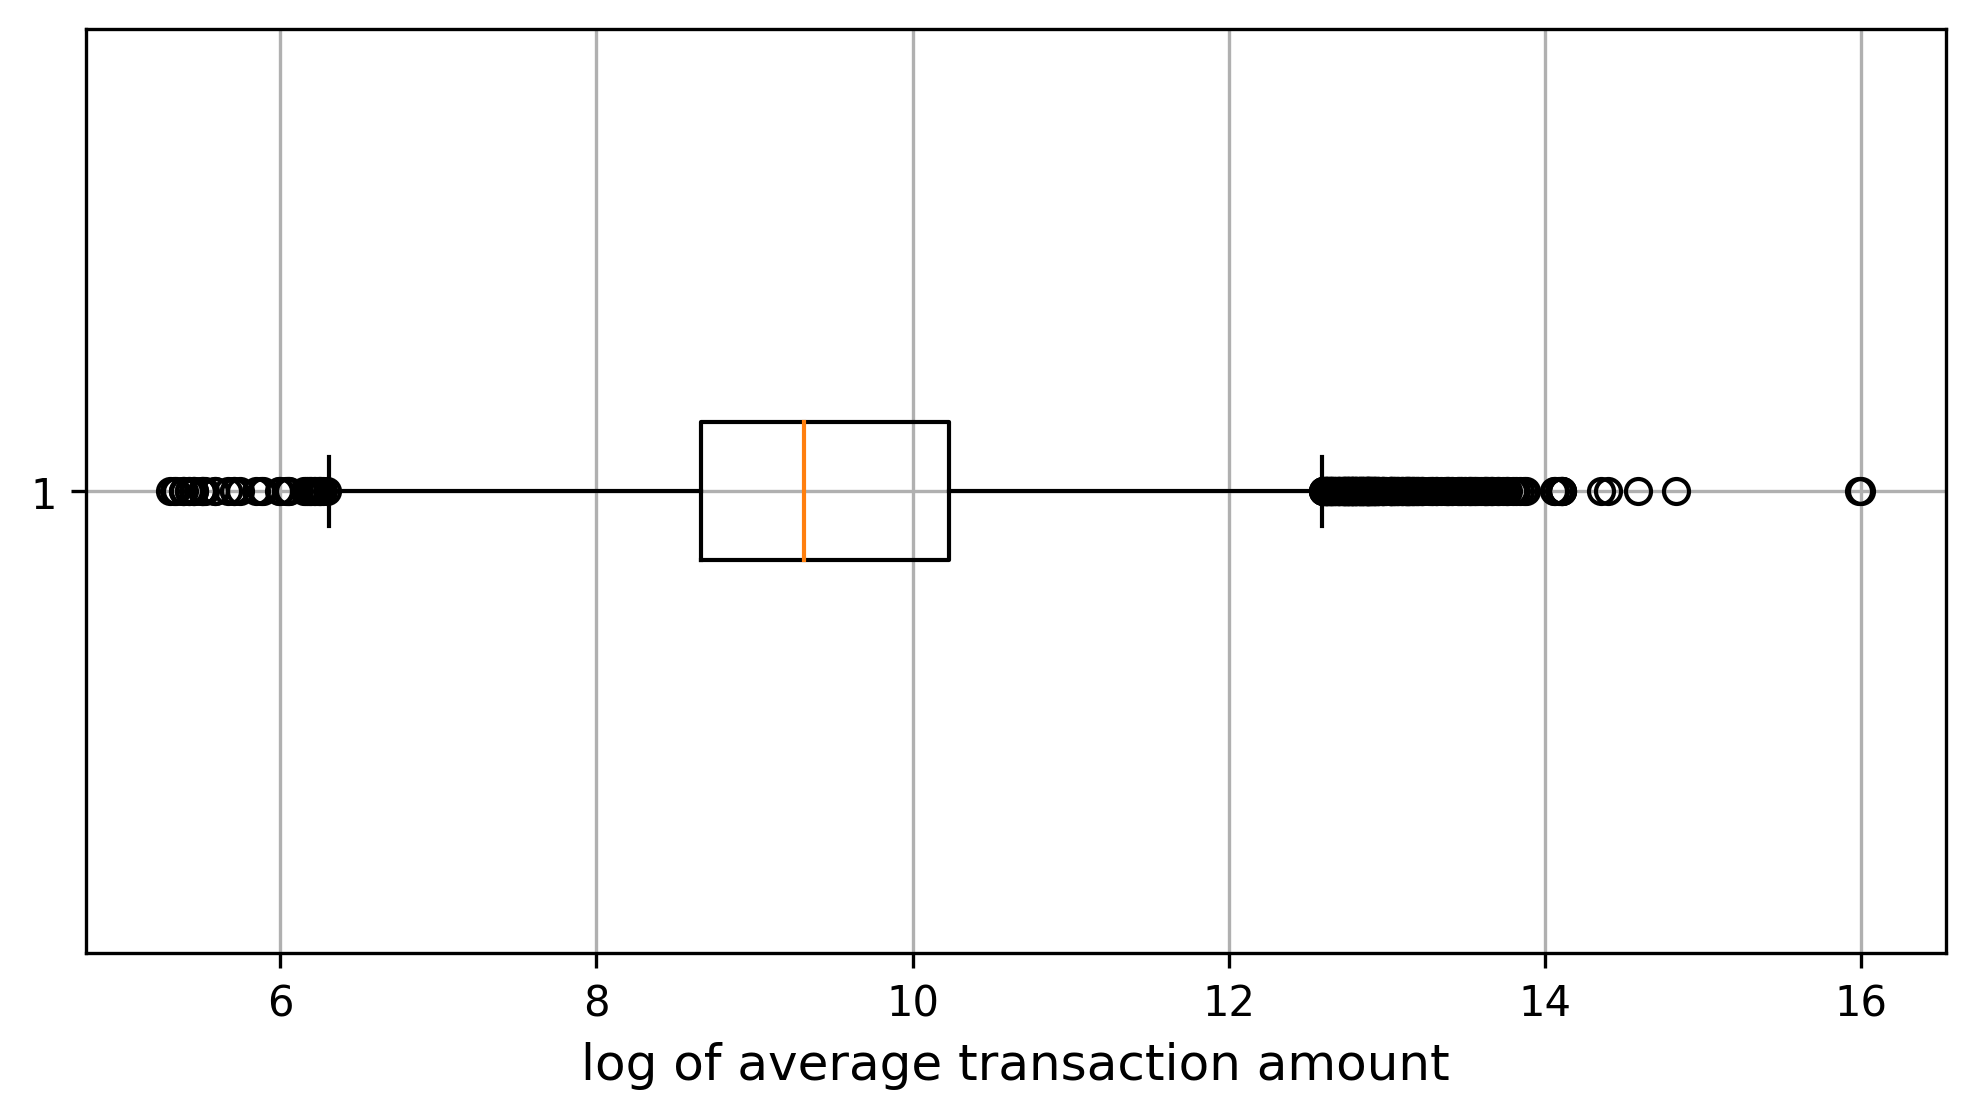

In [13]:
figure = plt.figure(figsize=(8, 4), dpi=300)
plt.boxplot(np.log(user.avg_amount), vert=False)
plt.xlabel(('log of average transaction amount'), size=12)
plt.grid()

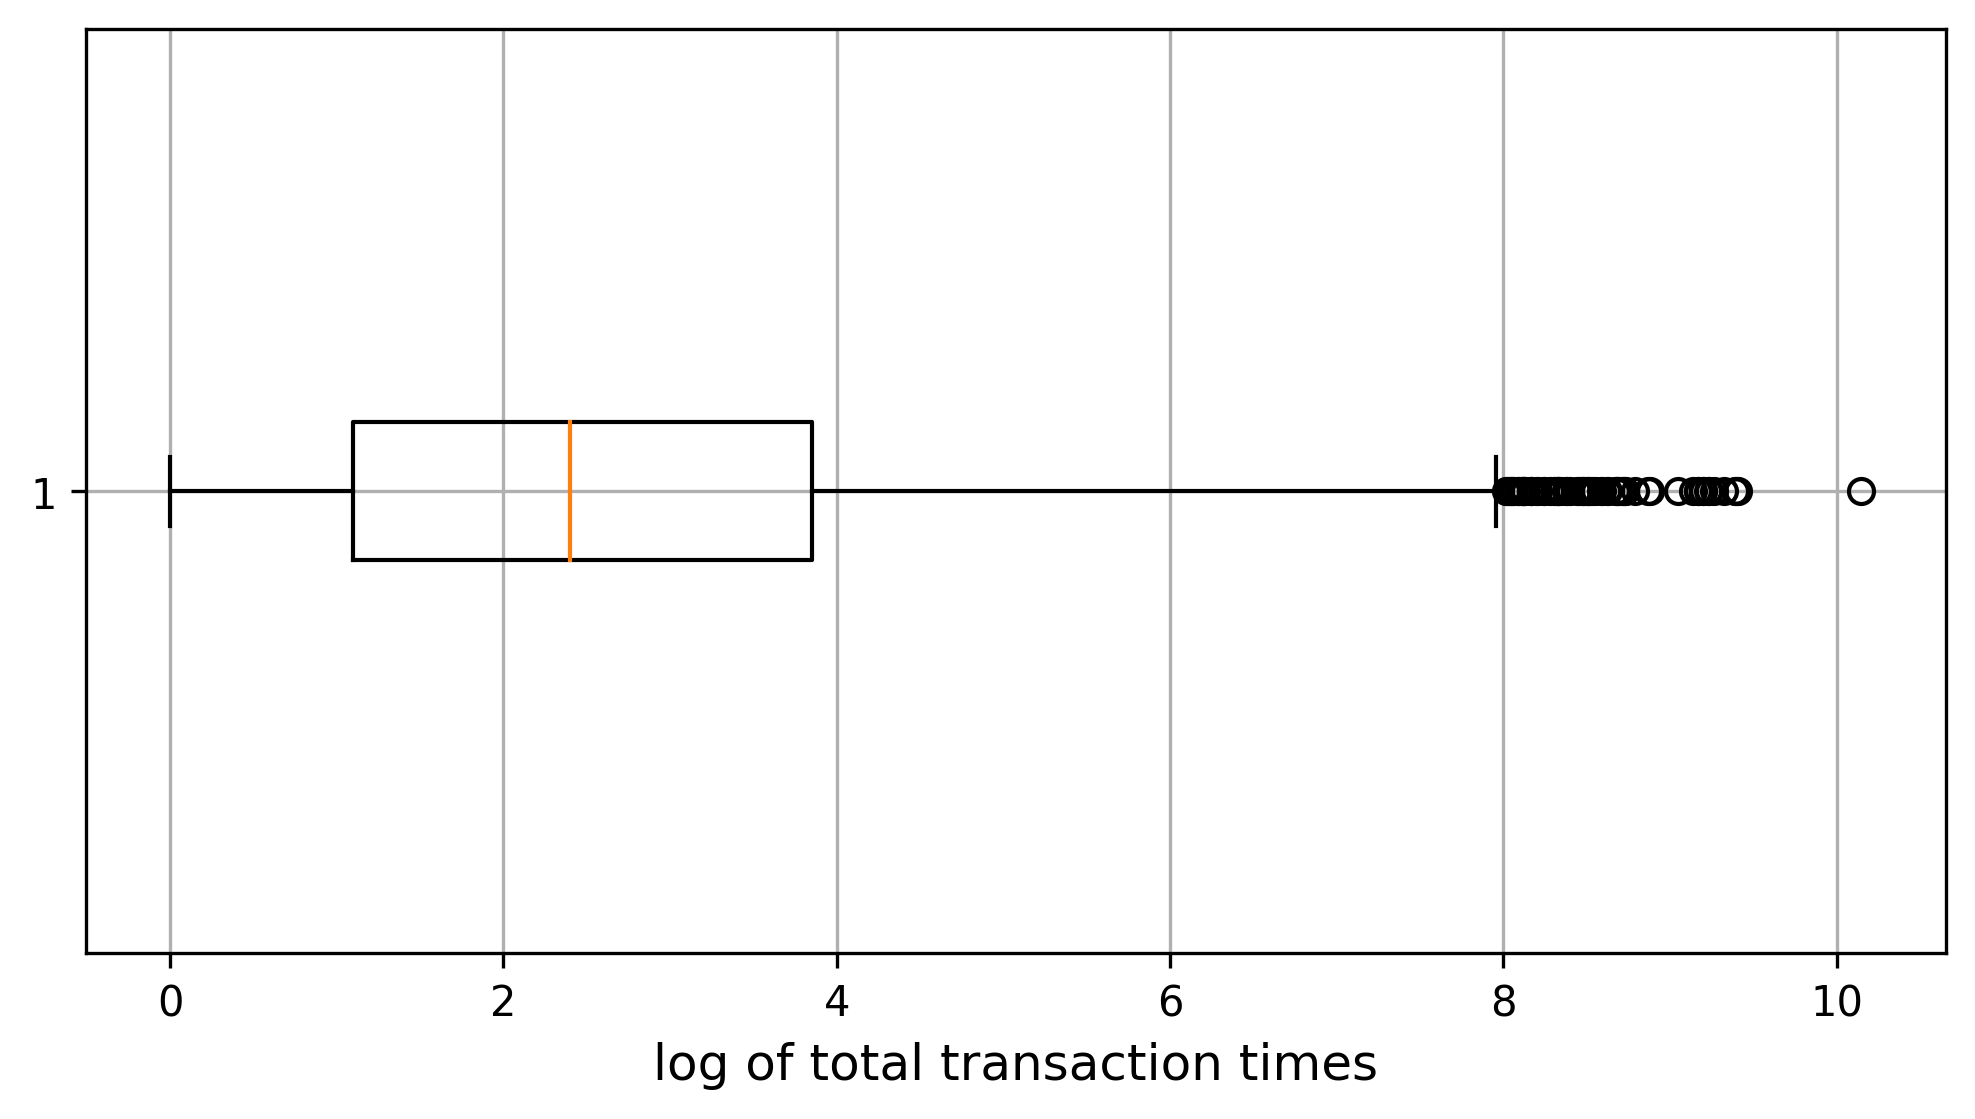

In [14]:
figure = plt.figure(figsize=(8, 4), dpi=300)
plt.boxplot(np.log(user.total_txn_times), vert=False)
plt.xlabel(('log of total transaction times'), size=12)
plt.grid()

In [15]:
# Therefore the data's variance is quite large

## implement an FM model to divide user group

In [16]:
# Basically i want to divide user group instead of predicting customer churn altogether. 
# I believe there are some counfounders here.
# RFM does not perfectly match our situation so we only use FM model to divide user group.
# To devide the group based on some threshold, how to determine the threshold is a problem here.

In [17]:
# Firstly I wanna try a threshold that could distinguish the churn rate between the divided two groups. That
# is to calculate the relationship between the gap and the threshold.

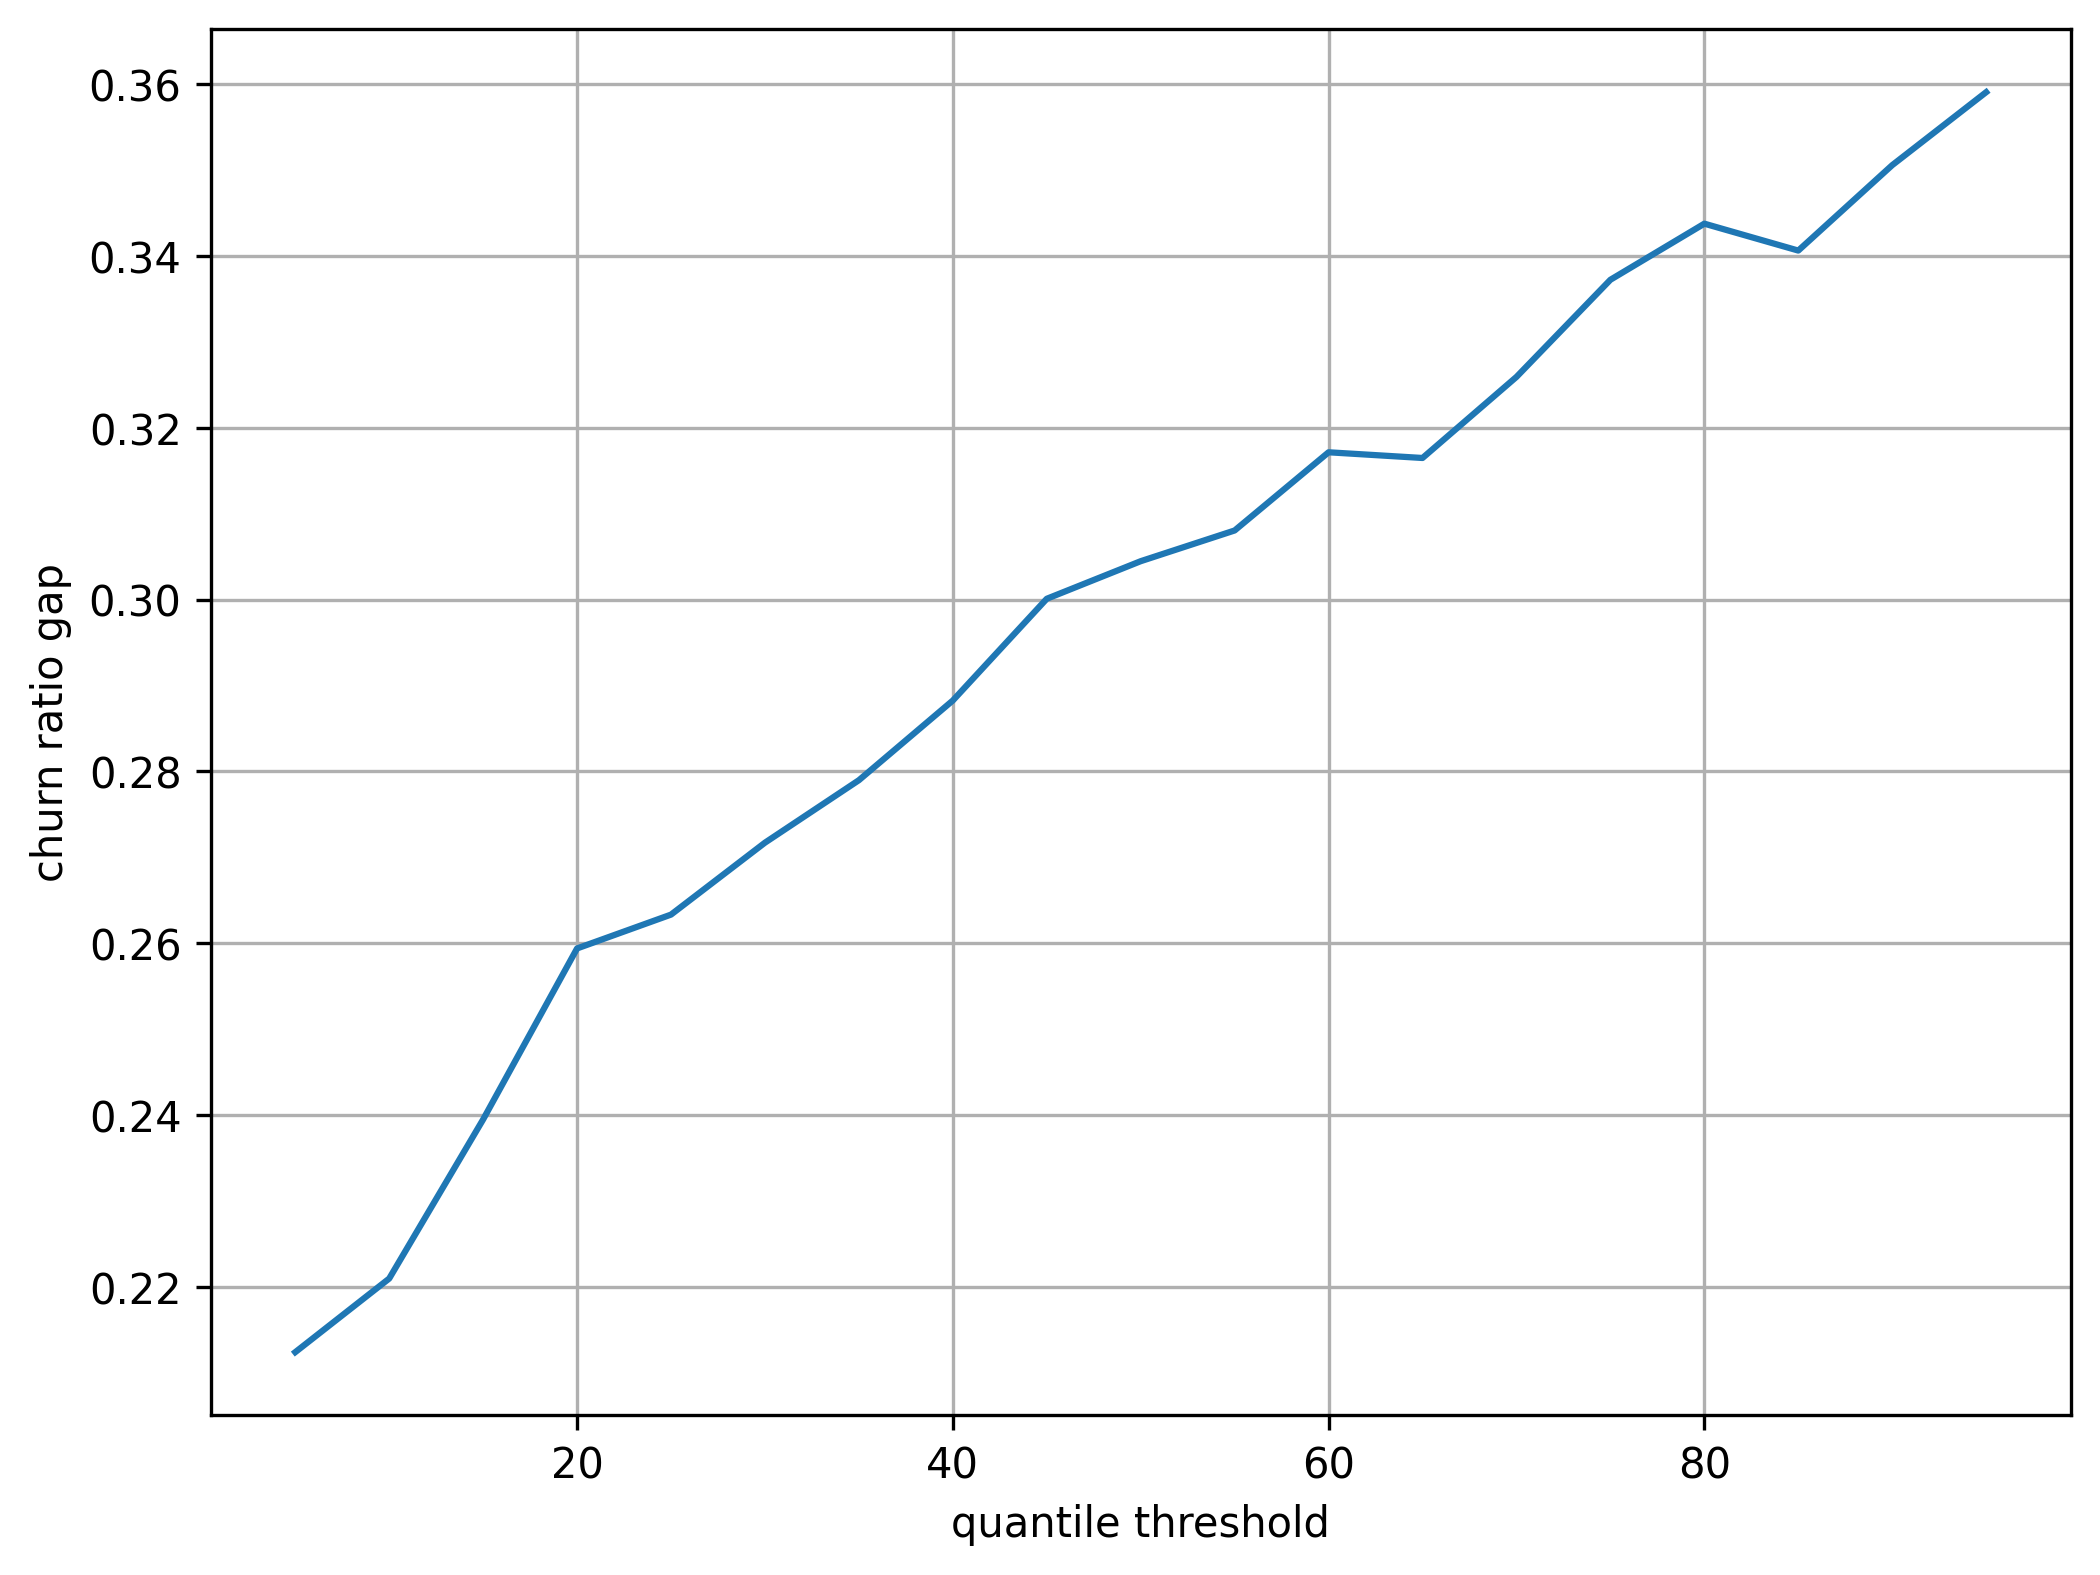

In [18]:
# for total amount
gap_list = []
for i in range(5, 100, 5):
    t = sorted(user.total_amount)[len(sorted(user.total_amount)) * i//100]
    gap = user[user['total_amount']<=t].churn.mean() - user[user['total_amount']>t].churn.mean()
    gap_list.append(gap)
    
figure = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(range(5, 100, 5), gap_list)
plt.ylabel('churn ratio gap')
plt.xlabel('quantile threshold')
plt.grid()

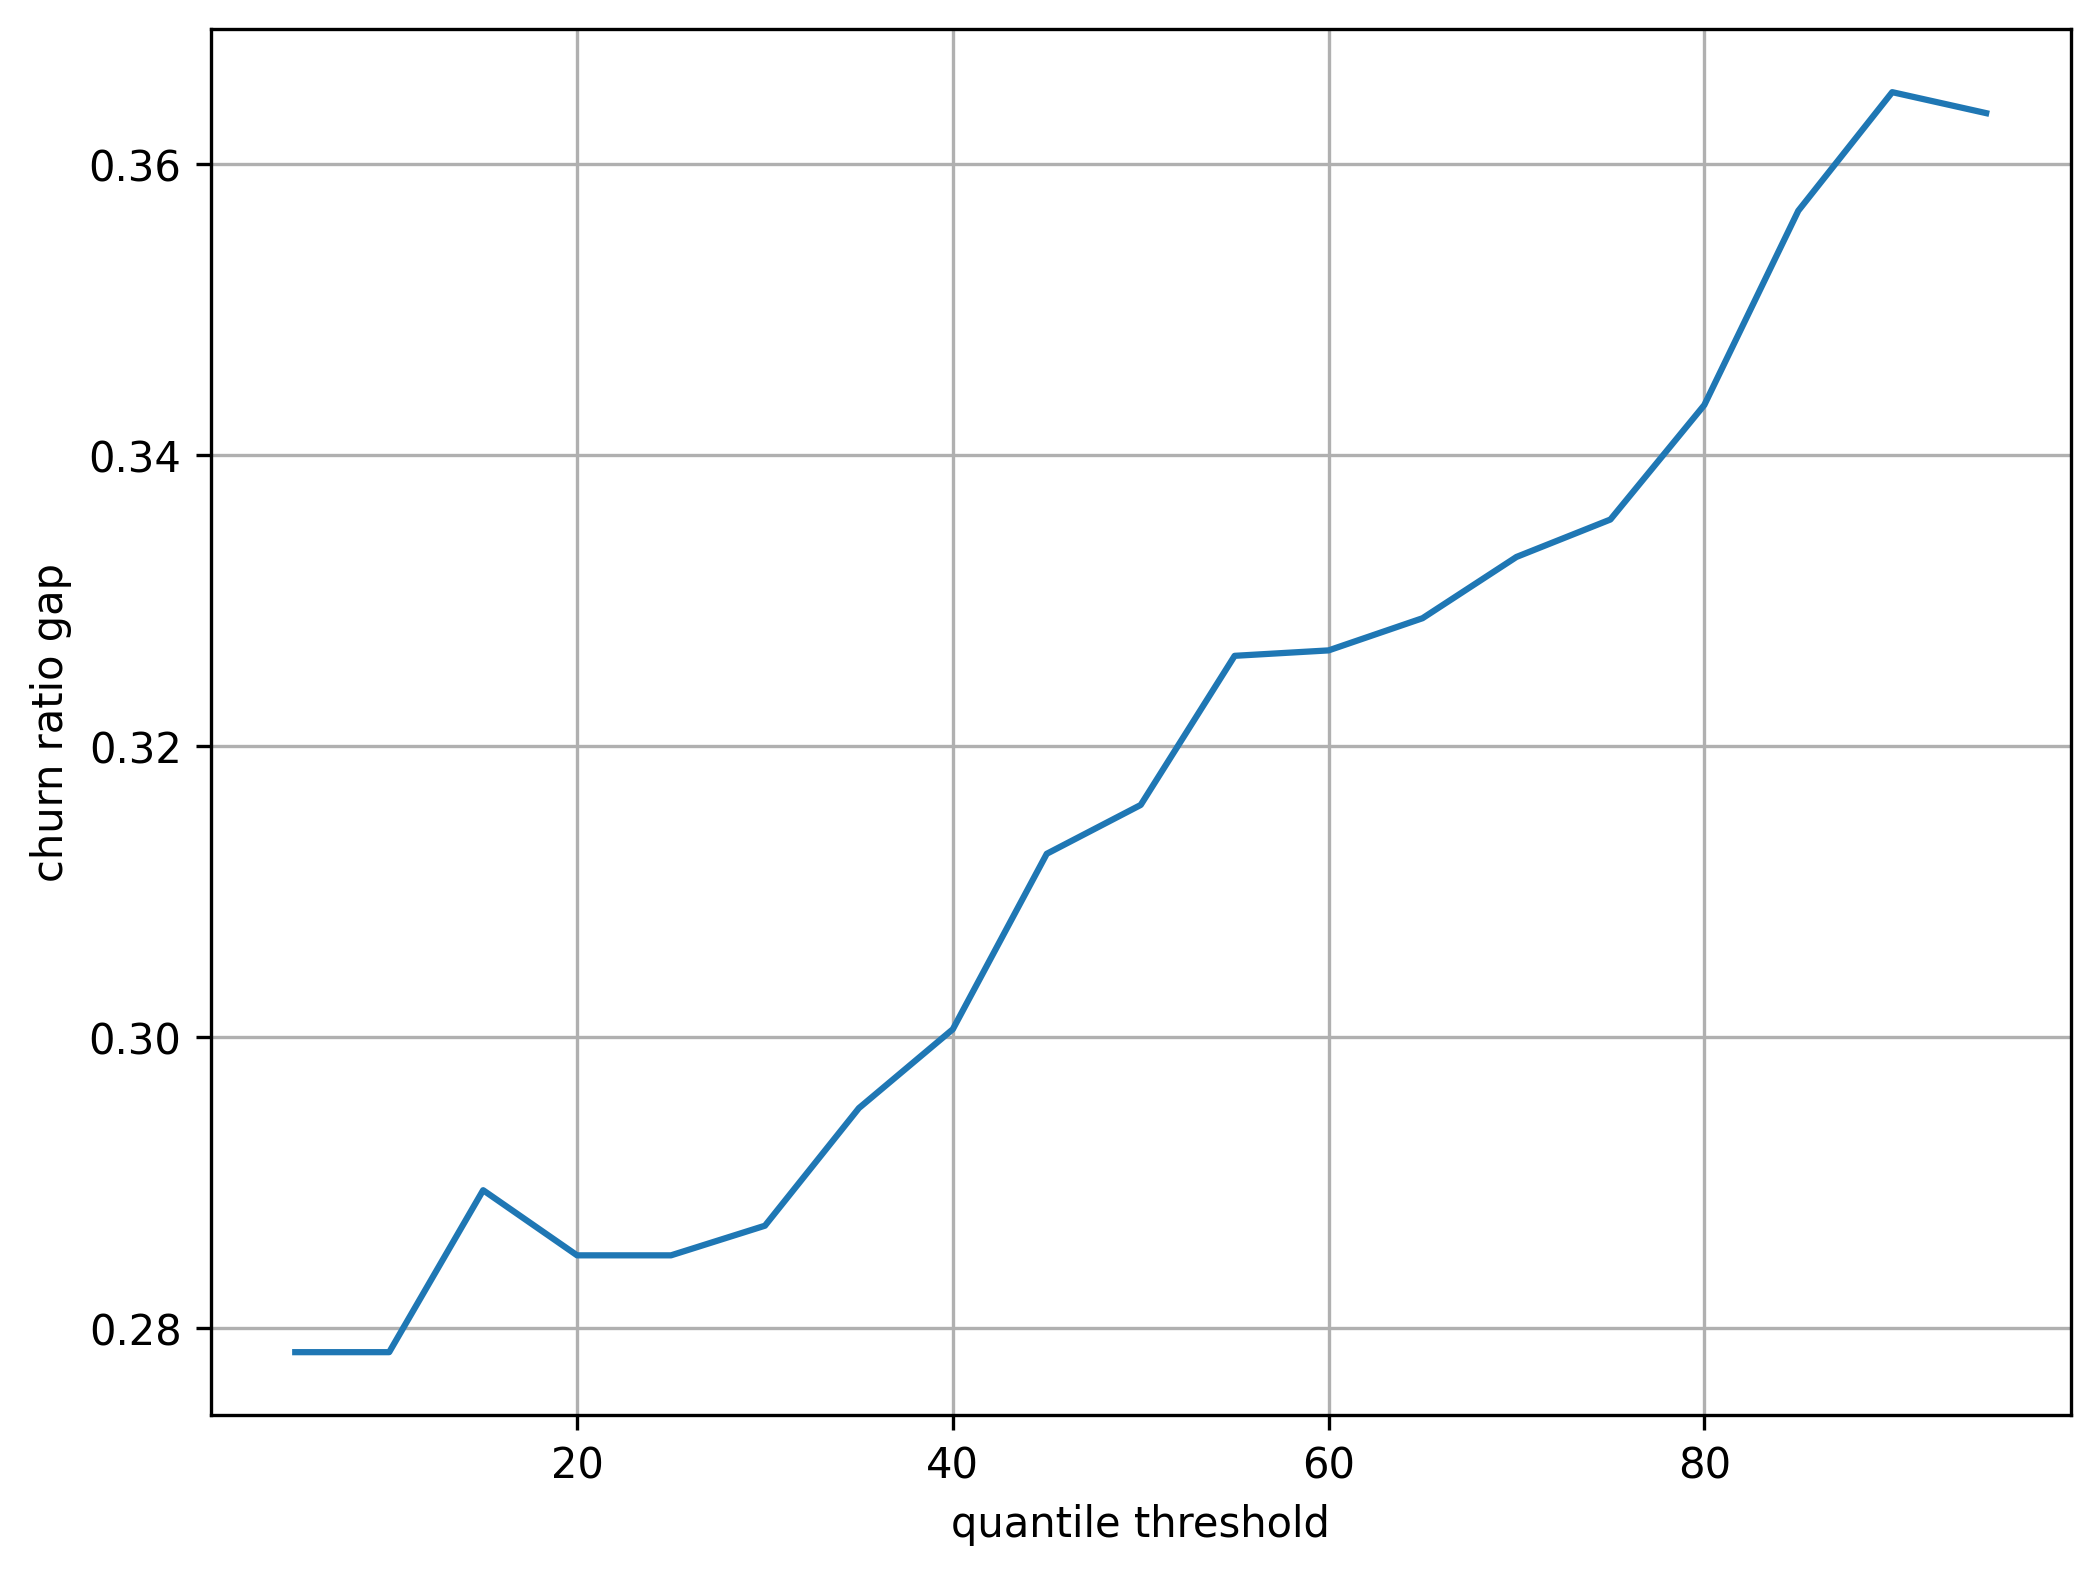

In [19]:
gap_list = []
for i in range(5, 100, 5):
    t = sorted(user.total_txn_times)[len(sorted(user.total_txn_times)) * i//100]
    gap = user[user['total_txn_times']<=t].churn.mean() - user[user['total_txn_times']>t].churn.mean()
    gap_list.append(gap)
    
figure = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(range(5, 100, 5), gap_list)
plt.ylabel('churn ratio gap')
plt.xlabel('quantile threshold')
plt.grid()

In [20]:
# Unfortunately there is no optimal threshold. The curve is monotone.

In [21]:
# assign merchants into groups
# user[['Frequency', 'Monetary']].to_csv('Merchant Business Type.csv')

In [22]:
def get_group_data(user, F=1, M=1):
    if F==-1 & M==-1:
        return user.reset_index(drop=True)
    da = user[(user['frequency_type']==F)&(user['monetary_type']==M)]
    print('===')
    print("For user with %s frequency and %s money. " % ('high' if F==1 else 'low', 'high' if M==1 else 'low'))
    if 'churn' in da.columns:
        print("Average churn rate: %.4f" % da.churn.mean())
    print("Data amount: %d" % da.shape[0])
    return da.reset_index(drop=True)

In [23]:
# See average churn rate in different type of merchants

In [24]:
for f in [1, 0]:
    for m in [1, 0]:
        get_group_data(user, f, m)

===
For user with high frequency and high money. 
Average churn rate: 0.1377
Data amount: 1888
===
For user with high frequency and low money. 
Average churn rate: 0.2706
Data amount: 850
===
For user with low frequency and high money. 
Average churn rate: 0.2694
Data amount: 850
===
For user with low frequency and low money. 
Average churn rate: 0.5437
Data amount: 10102


# For each group, select behaviors used for training model

In [25]:
def get_group_process_data(user, data, F=1, M=1):
    """Preprocess the group data, do feature engineering"""
    
    group_user = get_group_data(user, F, M)
    
    group_action = pd.merge(group_user.reset_index(drop=True), data.reset_index(drop=True), on='merchant')
    
    group_action['date_to_last'] = (group_action['last_txn_date'] - group_action['date']).dt.days
    
    # get past days' behaviors
    group_action_180_m = group_action[group_action['date_to_last']<180][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '180d_amount_usd_in_cents'})
    group_action_180_f = group_action[group_action['date_to_last']<180][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '180d_total_txn_times'})    
    
    
    group_action_90_m = group_action[group_action['date_to_last']<90][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '90d_amount_usd_in_cents'})
    group_action_90_f = group_action[group_action['date_to_last']<90][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '90d_total_txn_times'})    
    
    
    group_action_60_m = group_action[group_action['date_to_last']<60][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '60d_amount_usd_in_cents'})
    group_action_60_f = group_action[group_action['date_to_last']<60][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '60d_total_txn_times'})    
    
    
    group_action_30_m = group_action[group_action['date_to_last']<30][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '30d_amount_usd_in_cents'})
    group_action_30_f = group_action[group_action['date_to_last']<30][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '30d_total_txn_times'})    
        
    
    group_user = group_user.merge(
    group_action_180_m, on='merchant').merge(
    group_action_180_f, on='merchant').merge(
    group_action_90_m, on='merchant').merge(
    group_action_90_f, on='merchant').merge(
    group_action_60_m, on='merchant').merge(
    group_action_60_f, on='merchant').merge(
    group_action_30_m, on='merchant').merge(
    group_action_30_f, on='merchant')
    
    # feature engineering
    group_user['amount_hy_change'] = group_user['90d_amount_usd_in_cents']/3 - (group_user['180d_amount_usd_in_cents'] - group_user['90d_amount_usd_in_cents'])/3
    group_user['amount_mn_change'] = group_user['30d_amount_usd_in_cents'] - (group_user['60d_amount_usd_in_cents'] - group_user['30d_amount_usd_in_cents'])
    group_user['freq_hy_change'] = group_user['90d_total_txn_times']/3 - (group_user['180d_total_txn_times'] - group_user['90d_total_txn_times'])/3
    group_user['freq_mn_change'] = group_user['30d_total_txn_times'] - (group_user['60d_total_txn_times'] - group_user['30d_total_txn_times'])

    return group_user
    

# Let's wrap up our goal

So we have defined what churn is. That is a customer has had no transactions for contiguous `churn_day` days given a `spot`. 

Now our work is to predict customer churn, so how about customer behavior in the next month? I want to divide the dataset into training set and test set. I set a spot date named `training_spot`, and use the churn data at that observation date with labels to train a model. Then predict customers who are still active between `training_spot` and `spot`.

# Model training

## Define training set and test set

In [26]:
training_spot = datetime.strptime(spot, '%Y-%m-%d').date() - timedelta(days=churn_day+1)
training_spot = training_spot.strftime('%Y-%m-%d')
training_spot

'2034-11-01'

In [27]:
user_train = generate_user_data(data=data.loc[~(data['time']>=training_spot), :], spot=training_spot, churn_day=churn_day)
user_train = user_train.reset_index(drop=True)

/var/folders/57/47jcsk4j1j11kgyfzkdh89zh0000gn/T/ipykernel_21631/1706263635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data.loc[:, 'time'])  # transfer str to date


In [28]:
user_train

,merchant,last_txn_date,avg_amount,med_amount,total_amount,total_txn_times,gap_last_txn,churn,frequency_type,monetary_type
0,faa029c6b0,2034-10-31 19:30:30,17473.976526,14772.0,7443914,426,0,0,1,1
1,5608f200cf,2034-10-31 21:51:12,819.734795,820.0,19744952,24087,0,0,1,1
2,15b1a0d61e,2034-10-27 20:43:24,5875.650794,4491.0,2591162,441,4,0,1,1
3,4770051790,2034-10-30 15:06:22,42206.586592,30126.0,22664937,537,1,0,1,1
4,3fc4f08d9d,2034-10-29 16:29:47,5679.938724,6190.0,22339199,3933,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...
12241,41f6054841,2034-03-11 00:45:57,1233.000000,1233.0,1233,1,234,1,0,0
12242,cce748c02b,2033-08-15 15:05:50,406528.000000,406528.0,406528,1,442,1,0,0
12243,7dd807a637,2033-12-13 15:16:21,31361.000000,31361.0,31361,1,322,1,0,0
12244,314ea3d710,2034-08-29 01:19:37,2068.000000,2068.0,2068,1,63,1,0,0


In [29]:
user_test = user[user['last_txn_date'] >= training_spot].reset_index(drop=True)
user_test['gap_last_txn'] = (pd.to_datetime(spot) - user_test['last_txn_date']).dt.days
user_test = user_test.drop(columns=['churn'])

In [30]:
user_test

,merchant,last_txn_date,avg_amount,med_amount,total_amount,total_txn_times,gap_last_txn,frequency_type,monetary_type
0,faa029c6b0,2034-12-30 20:57:25,16729.992647,14599.0,9101116,544,1,1,1
1,ed7a7d91aa,2034-12-27 00:40:38,16958.500000,6492.0,271336,16,4,0,0
2,5608f200cf,2034-12-31 04:44:54,819.675878,820.0,20911571,25512,0,1,1
3,15b1a0d61e,2034-12-30 21:21:42,5765.639155,4466.0,3003898,521,1,1,1
4,4770051790,2034-12-31 02:52:53,45291.076655,28854.5,25997078,574,0,1,1
...,...,...,...,...,...,...,...,...,...
7522,6657e4d6a3,2034-12-03 20:27:46,3347.000000,3347.0,3347,1,28,0,0
7523,f2c5206eb6,2034-12-26 19:33:18,401.000000,401.0,401,1,5,0,0
7524,40416a82d1,2034-11-06 00:35:53,1199.000000,1199.0,1199,1,55,0,0
7525,00607c6461,2034-12-21 15:02:45,50094.000000,50094.0,50094,1,10,0,0


## Split training set and validation set

In [31]:
group_user = get_group_process_data(user_train, data, F=-1, M=-1)

columns = [
    'amount_hy_change', 
    'amount_mn_change',
    'freq_hy_change',
    'freq_mn_change',
    '30d_total_txn_times',
    '60d_total_txn_times',
    '90d_total_txn_times',
    '180d_total_txn_times',
    '30d_amount_usd_in_cents',
    '60d_amount_usd_in_cents',
    '90d_amount_usd_in_cents',
    '180d_amount_usd_in_cents'
]

X, y = group_user[columns], group_user['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)  

## Compare common ML models

In [64]:
models = {
    'XGBoost': XGBClassifier(),
    'GBDT': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Gaussian Naive Bayesian': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regresion': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC()
}

In [65]:
for model_name, classifier in models.items():
    model = classifier
    model.fit(X_train, y_train)
    print("%s: %.4f" % (model_name, cross_val_score(model, X_train, y_train, cv=5).mean()))

XGBoost: 0.6858
GBDT: 0.7018
Random Forest: 0.6611
AdaBoost: 0.6994
Extra Trees: 0.6523
Gaussian Naive Bayesian: 0.4902
KNN: 0.6385
Logistic Regresion: 0.5629
Decision Tree: 0.6193
SVM: 0.6239


## Test XGBoost model

In [34]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_pred = xgb.predict(X_val)

print("Training Set:")
print("Xgboost %.4f" % xgb.score(X_train, y_train))
print("Summary\n", metrics.classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))

print("Validation Set:")
print("Xgboost %.4f" % xgb.score(X_val, y_val))
print("Summary\n", metrics.classification_report(y_val, y_pred))
print("Confusion Matrix:\n", metrics.confusion_matrix(y_val, y_pred))

Training Set:
Xgboost 0.8576
Summary
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5508
           1       0.82      0.87      0.84      4288

    accuracy                           0.86      9796
   macro avg       0.86      0.86      0.86      9796
weighted avg       0.86      0.86      0.86      9796

Confusion Matrix:
 [[4660  848]
 [ 547 3741]]
Validation Set:
Xgboost 0.6780
Summary
               precision    recall  f1-score   support

           0       0.72      0.70      0.71      1377
           1       0.63      0.65      0.64      1073

    accuracy                           0.68      2450
   macro avg       0.67      0.67      0.67      2450
weighted avg       0.68      0.68      0.68      2450

Confusion Matrix:
 [[964 413]
 [376 697]]


### tune hyperparameter set

In [35]:
grids = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1e-5,
    'reg_lambda': 1
}

In [36]:
def tune_lr(X, y, grids, cv=5, learning_rate_grid = [0.01, 0.015, 0.025, 0.05, 0.1]):
    param_test0 = {
        'learning_rate': learning_rate_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test0,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['learning_rate'] = gsearch.best_params_['learning_rate']

In [37]:
def tune_depth_weight(X, y, grids, cv=5, max_depth_grid=[i for i in range(3, 10, 2)], min_child_weight_grid=[i for i in range(1, 6, 2)]):
    param_test1 = {
        'max_depth': max_depth_grid,
        'min_child_weight': min_child_weight_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test1,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['max_depth'] = gsearch.best_params_['max_depth']
    grids['min_child_weight'] = gsearch.best_params_['min_child_weight']
    

In [38]:
def tune_gamma(X, y, grids, cv=5, gamma_grid=[i/10.0 for i in range(0, 5)]):
    param_test2 = {
        'gamma': gamma_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test2,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )
    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['gamma'] = gsearch.best_params_['gamma']
    

In [39]:
def tune_sample(X, y, grids, cv=5, subsample_grid=[i/10.0 for i in range(6, 10)], colsample_grid=[i/10.0 for i in range(6, 10)]):
    param_test3 = {
        'subsample': subsample_grid,
        'colsample_bytree': colsample_grid
    }
    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),
        param_grid = param_test3,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )
    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['subsample'] = gsearch.best_params_['subsample']
    grids['colsample_bytree'] = gsearch.best_params_['colsample_bytree']
    

In [40]:
def tune_alpha(X, y, grids, cv=5, alpha_grid=[1e-5, 1e-2, 0.1, 1, 100]):
    param_test4 = {
        'reg_alpha': alpha_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),

        param_grid = param_test4,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['reg_alpha'] = gsearch.best_params_['reg_alpha']

In [41]:
def tune_lambda(X, y, grids, cv=5, lambda_grid=[1e-5, 1e-2, 0.1, 1, 100]):
    param_test5 = {
        'reg_lambda': lambda_grid
    }

    gsearch = GridSearchCV(
        estimator = XGBClassifier(
            n_estimators = 140, 
            **grids,
            objective = 'binary:logistic',
            nthread = 4,
            scale_pos_weight = 1,
            seed = 27
        ),

        param_grid = param_test5,
        scoring = 'roc_auc',
        n_jobs = 4,
        cv = cv
    )

    gsearch.fit(X_train, y_train)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['reg_lambda'] = gsearch.best_params_['reg_lambda']

In [42]:
def tune_XGBoost(X, y, CV=5):
    
    grids = {
        'learning_rate': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 1e-5,
        'reg_lambda': 1
    }
    
    tune_lr(X, y, grids, cv=CV)
    tune_depth_weight(X, y, grids, cv=CV)

    tune_gamma(X, y, grids, cv=CV)
    tune_sample(X, y, grids, cv=CV)
    tune_alpha(X, y, grids, cv=CV)
    tune_lambda(X, y, grids, cv=CV)
    
    return grids

## Test GBDT model

In [43]:
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)

y_train_pred = gbdt.predict(X_train)
y_val_pred = gbdt.predict(X_val)

cv_score = cross_val_score(gbdt, X_train, y_train, cv=5, scoring='roc_auc')

print("Model Report")
print("Accuracy : {0:.4}".format(metrics.accuracy_score(y_train.values, y_train_pred)))
print("AUC Score (Train): {0:.4}".format(metrics.roc_auc_score(y_train.values, y_train_pred)))
print("AUC Score (Val): {0:.4}".format(metrics.roc_auc_score(y_val.values, y_val_pred)))

print("CV Score : Mean - {0:.7} | Std - {1:.7} | Min - {2:.7} | Max - {3:.7}".\
      format(np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

Model Report
Accuracy : 0.7324
AUC Score (Train): 0.7291
AUC Score (Val): 0.6851
CV Score : Mean - 0.7752909 | Std - 0.003503179 | Min - 0.7694328 | Max - 0.7785855


In [44]:
def tune_estimators(X, y, grids, cv=5, estimators_grid=range(20, 81, 10)):
    param_test0 = {
        'n_estimators': estimators_grid
    }

    gsearch = GridSearchCV(
        estimator = GradientBoostingClassifier(
            **grids,
            max_features='sqrt',
            random_state=42
        ),
        param_grid=param_test0,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['n_estimators'] = gsearch.best_params_['n_estimators']

In [45]:
def tune_depth(X, y, grids, cv=5, max_depth_grid=range(5, 16, 2), split_grid=range(200, 2001, 200)):
    param_test1 = {
        'max_depth': max_depth_grid, 
        'min_samples_split': split_grid,
    }

    gsearch = GridSearchCV(
        estimator = GradientBoostingClassifier(
            **grids,
            max_features='sqrt',
            random_state=42
        ),
        param_grid=param_test1,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['max_depth'] = gsearch.best_params_['max_depth']
    grids['min_samples_split'] = gsearch.best_params_['min_samples_split']
    

In [46]:
def tune_leaf(X, y, grids, cv=5, leaf_grid=range(30, 71, 10)):
    param_test2 = {
        'min_samples_leaf': leaf_grid
    }

    gsearch = GridSearchCV(
        estimator = GradientBoostingClassifier(
            **grids,
            max_features='sqrt',
            random_state=42
        ),
        param_grid=param_test2,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['min_samples_leaf'] = gsearch.best_params_['min_samples_leaf']
    

In [47]:
def tune_subsample(X, y, grids, cv=5, subsample_grid=[0.6,0.7,0.75,0.8,0.85,0.9]):
    param_test3 = {
        'subsample': subsample_grid
    }

    gsearch = GridSearchCV(
        estimator = GradientBoostingClassifier(
            **grids,
            max_features='sqrt',
            random_state=42
        ),
        param_grid=param_test3,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv
    )

    gsearch.fit(X, y)
    
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    
    grids['subsample'] = gsearch.best_params_['subsample']

In [48]:
def tune_GBDT(X, y, CV=5):
    
    grids = {
        'n_estimators': 40,
        'learning_rate': 0.1,
        'min_samples_split': 800,
        'min_samples_leaf': 30,
        'max_depth': 13,
        'subsample': 0.8
    }

    tune_estimators(X, y, grids, cv=CV)
    tune_depth(X, y, grids, cv=CV)
    tune_leaf(X, y, grids, cv=CV)
    tune_subsample(X, y, grids, cv=CV)
    
    return grids

## Train models

In [50]:
def train_model_GBDT(F, M, data, user_train, user_test):

    group_user = get_group_process_data(user_train, data, F, M)
    group_user_test = get_group_process_data(user_test, data, F, M)

    columns = [
        'amount_hy_change', 
        'amount_mn_change',
        'freq_hy_change',
        'freq_mn_change',
        '30d_total_txn_times',
        '60d_total_txn_times',
        '90d_total_txn_times',
        '180d_total_txn_times',
        '30d_amount_usd_in_cents',
        '60d_amount_usd_in_cents',
        '90d_amount_usd_in_cents',
        '180d_amount_usd_in_cents'
    ]

    X, y = group_user[columns], group_user['churn']

    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)  

    grids = tune_GBDT(X_train, y_train, CV=5)
    grids['learning_rate'] = 0.05
    grids['n_estimators'] = 80
    
    gbdt_classifier = GradientBoostingClassifier(
        **grids,
        max_features='sqrt',
        random_state=42
    )
    
    gbdt_classifier.fit(X_train, y_train)
    
    fig = plt.figure(figsize=(12, 8), dpi=800)
    feature_data = pd.DataFrame([X_train.columns, gbdt_classifier.feature_importances_], index=['features', 'importance']).T
    feature_data = feature_data.sort_values(by='importance')
    plt.barh(feature_data['features'], feature_data['importance'])
    plt.ylabel('Features', size=20)
    plt.xlabel("Imoprtance index", size=20)
    plt.grid()
    plt.show()

    y_train_pred = gbdt.predict(X_train)
    y_val_pred = gbdt.predict(X_val)
    
    print('=' * 40)
    print("training set result:")
    print(classification_report(y_train, y_train_pred))
    print('=' * 40)
    print("validation set result:")
    print(classification_report(y_val, y_val_pred))
    
    print("Accuracy : {0:.4}".format(metrics.accuracy_score(y_train.values, y_train_pred)))
    print("AUC Score (Train): {0:.4}".format(metrics.roc_auc_score(y_train.values, y_train_pred)))
    print("AUC Score (Val): {0:.4}".format(metrics.roc_auc_score(y_val.values, y_val_pred)))

    return gbdt_classifier.predict(X_val), y_val


In [53]:
def train_model_xgb(F, M, data, user_train, user_test):

    group_user = get_group_process_data(user_train, data, F, M)
    group_user_test = get_group_process_data(user_test, data, F, M)

    columns = [
        'amount_hy_change', 
        'amount_mn_change',
        'freq_hy_change',
        'freq_mn_change',
        '30d_total_txn_times',
        '60d_total_txn_times',
        '90d_total_txn_times',
        '180d_total_txn_times',
        '30d_amount_usd_in_cents',
        '60d_amount_usd_in_cents',
        '90d_amount_usd_in_cents',
        '180d_amount_usd_in_cents'
    ]

    X, y = group_user[columns], group_user['churn']

    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)  

    grids = tune_XGBoost(X_train, y_train, CV=5)
    
    xgb_classifier = XGBClassifier(
        n_estimators = 400, 
        **grids,
        objective = 'binary:logistic',
        nthread = 4,
        scale_pos_weight = 1,
        seed = 27
    )
    
    xgb_classifier.fit(X_train, y_train)

    print('=' * 40)
    print("training set result:")
    print(classification_report(y_train, xgb_classifier.predict(X_train)))
    print('=' * 40)
    print("validation set result:")
    print(classification_report(y_val, xgb_classifier.predict(X_val)))

    test_set = group_user_test[columns]

#     fig = plt.figure(figsize=(12, 8), dpi=800)
#     feature_data = pd.DataFrame([X_train.columns, xgb_classifier.feature_importances_], index=['features', 'importance']).T
#     feature_data = feature_data.sort_values(by='importance')
    
#     plt.barh(feature_data['features'], feature_data['importance'])
#     plt.ylabel('Features', size=20)
#     plt.xlabel("Imoprtance index", size=20)
    plot_importance(xgb_classifier)
#     plt.grid()
    plt.show()

#     test_set['churn'] = xgb_classifier.predict(test_set[columns])
#     test_set['merchant'] = group_user_test['merchant']

#     test_outcome = test_set[['merchant', 'churn']]
    
    return xgb_classifier.predict(X_val), y_val



## Run models on 4 types of merchants

===
For user with high frequency and high money. 
Average churn rate: 0.1327
Data amount: 1666
===
For user with high frequency and high money. 
Data amount: 1630
{'learning_rate': 0.025}
0.8542915550058406
{'max_depth': 7, 'min_child_weight': 3}
0.8599295677867108
{'gamma': 0.0}
0.8599295677867108
{'colsample_bytree': 0.8, 'subsample': 0.8}
0.8599295677867108
{'reg_alpha': 1e-05}
0.8599295677867108
{'reg_lambda': 1}
0.7771710181018857
training set result:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1155
           1       0.97      0.85      0.91       177

    accuracy                           0.98      1332
   macro avg       0.98      0.92      0.95      1332
weighted avg       0.98      0.98      0.98      1332

validation set result:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       290
           1       0.65      0.39      0.49        44

    accuracy             

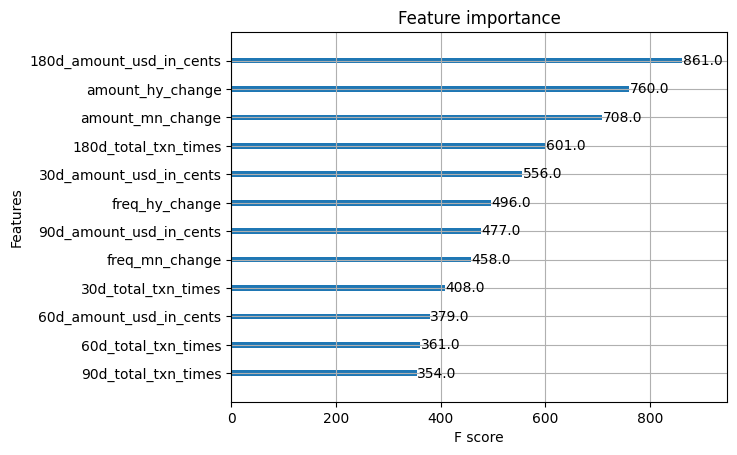

===
For user with high frequency and low money. 
Average churn rate: 0.2798
Data amount: 779
===
For user with high frequency and low money. 
Data amount: 620
{'learning_rate': 0.025}
0.793237465772826
{'max_depth': 5, 'min_child_weight': 5}
0.7945026489996747
{'gamma': 0.0}
0.7945026489996747
{'colsample_bytree': 0.9, 'subsample': 0.9}
0.8000956997031021
{'reg_alpha': 1e-05}
0.8000956997031021
{'reg_lambda': 0.1}
0.780086330406037
training set result:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       449
           1       0.91      0.86      0.88       174

    accuracy                           0.94       623
   macro avg       0.93      0.91      0.92       623
weighted avg       0.94      0.94      0.94       623

validation set result:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       112
           1       0.65      0.59      0.62        44

    accuracy                 

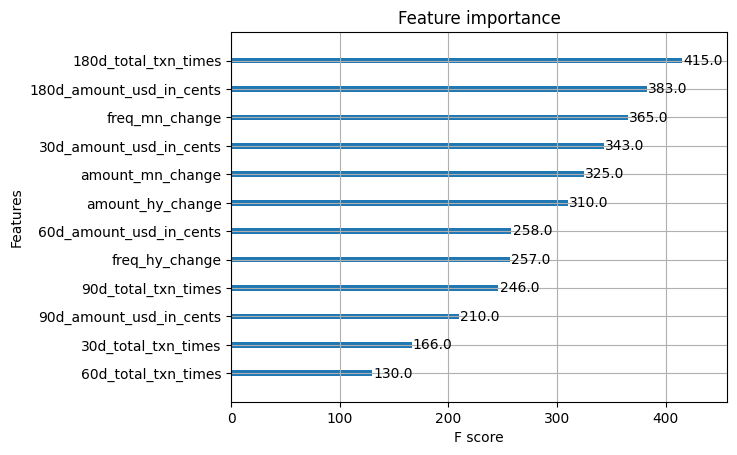

===
For user with low frequency and high money. 
Average churn rate: 0.2401
Data amount: 783
===
For user with low frequency and high money. 
Data amount: 632
{'learning_rate': 0.01}
0.7188099415204678
{'max_depth': 9, 'min_child_weight': 1}
0.7208815789473684
{'gamma': 0.0}
0.7208815789473684
{'colsample_bytree': 0.7, 'subsample': 0.6}
0.7229517543859648
{'reg_alpha': 1e-05}
0.7229517543859648
{'reg_lambda': 1}
0.7754899276511471
training set result:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       476
           1       0.99      0.81      0.89       150

    accuracy                           0.95       626
   macro avg       0.97      0.90      0.93       626
weighted avg       0.95      0.95      0.95       626

validation set result:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       119
           1       0.67      0.32      0.43        38

    accuracy                  

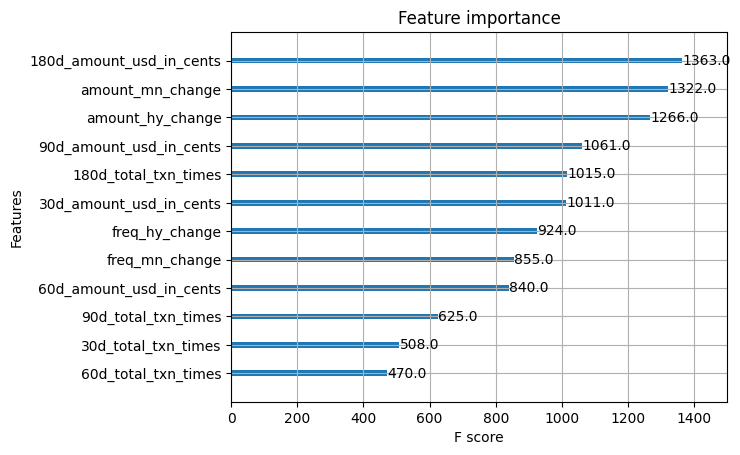

===
For user with low frequency and low money. 
Average churn rate: 0.5250
Data amount: 9018
===
For user with low frequency and low money. 
Data amount: 4645
{'learning_rate': 0.015}
0.7217165000448377
{'max_depth': 5, 'min_child_weight': 3}
0.7221521381430648
{'gamma': 0.3}
0.722389392642621
{'colsample_bytree': 0.8, 'subsample': 0.7}
0.7228162258118603
{'reg_alpha': 0.01}
0.7228686240520922
{'reg_lambda': 0.1}
0.7790423274864439
training set result:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      3427
           1       0.72      0.80      0.76      3787

    accuracy                           0.73      7214
   macro avg       0.73      0.73      0.73      7214
weighted avg       0.73      0.73      0.73      7214

validation set result:
              precision    recall  f1-score   support

           0       0.67      0.58      0.63       857
           1       0.66      0.74      0.70       947

    accuracy                 

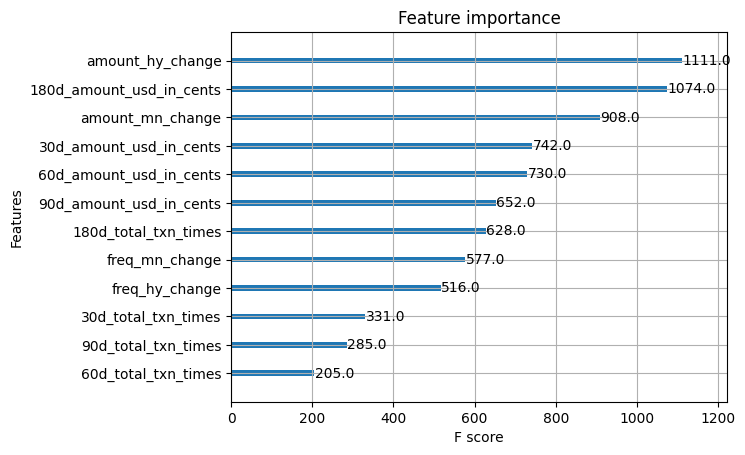

In [54]:
outcome = []
for f in [1, 0]:
    for m in [1, 0]:
        oc = train_model_xgb(f, m, data=data, user_train=user_train, user_test=user_test)
        outcome.append(oc)

# Output result

In [55]:
# what if no confounder exclusion

{'learning_rate': 0.025}
0.7794123252781198
{'max_depth': 5, 'min_child_weight': 5}
0.7801221669968095
{'gamma': 0.4}
0.7801593170519222
{'colsample_bytree': 0.9, 'subsample': 0.6}
0.7805478743612321
{'reg_alpha': 1}
0.7807668834524899
{'reg_lambda': 1}
0.7807668834524899
training set result:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      5508
           1       0.72      0.76      0.74      4288

    accuracy                           0.76      9796
   macro avg       0.76      0.76      0.76      9796
weighted avg       0.76      0.76      0.76      9796

validation set result:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1377
           1       0.64      0.65      0.64      1073

    accuracy                           0.68      2450
   macro avg       0.68      0.68      0.68      2450
weighted avg       0.68      0.68      0.68      2450



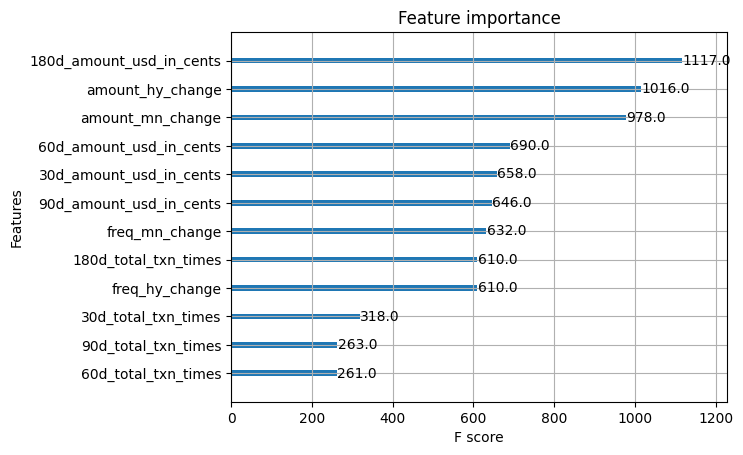

In [56]:
one_model = train_model_xgb(F=-1, M=-1, data=data, user_train=user_train, user_test=user_test)

In [57]:
GBDT = train_model_GBDT(F=-1, M=-1, data=data, user_train=user_train, user_test=user_test)

{'n_estimators': 40}
0.78074653443326
{'max_depth': 13, 'min_samples_split': 800}
0.78074653443326
{'min_samples_leaf': 30}
0.78074653443326
{'subsample': 0.8}
0.78074653443326


training set result:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      5508
           1       0.69      0.70      0.70      4288

    accuracy                           0.73      9796
   macro avg       0.73      0.73      0.73      9796
weighted avg       0.73      0.73      0.73      9796

validation set result:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1377
           1       0.65      0.64      0.65      1073

    accuracy                           0.69      2450
   macro avg       0.69      0.69      0.69      2450
weighted avg       0.69      0.69      0.69      2450

Accuracy : 0.7324
AUC Score (Train): 0.7291
AUC Score (Val): 0.6851


In [58]:
# final_result = pd.concat([outcome[i] for i in range(4)])[['merchant', 'churn']]
# final_result = final_result.merge(user_test[['merchant', 'frequency_type', 'monetary_type']], on='merchant')
# final_result.to_csv('final churn prediction update.csv', index=False)

In [59]:
true_predict = 0
all_user = 0
for i in range(4):
    true_predict += sum((outcome[i][0] == outcome[i][1]))
    all_user += len(outcome[i][0])

In [60]:
print("Accuracy of 4 models combined: %.4f" % (true_predict / all_user))
print("Accuracy of one model: %.4f" % (one_model[0] == one_model[1]).mean())

Accuracy of 4 models combined: 0.7152
Accuracy of one model: 0.6837


# Reference

In [ ]:
# https://cloud.tencent.com/developer/article/1656126
# https://7125messi.github.io/post/gbdt%E8%B0%83%E4%BC%98%E8%AF%A6%E8%A7%A3/